# Download and test pretrained mobilenet model using keras

In [72]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
import PIL.Image as Image
import urllib, json 
import sagemaker

In [3]:
IMG_SIZE = 224
IMAGE_SHAPE = (IMG_SIZE,IMG_SIZE,3)

In [4]:
classifier = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

Download test image

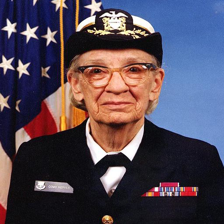

In [27]:
urllib.request.urlretrieve("https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg", "image.jpg")
image = Image.open("image.jpg").resize((IMG_SIZE,IMG_SIZE))
image

 Download mobilenet standard labels

In [28]:
urllib.request.urlretrieve("https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt", "labels.txt")
with open('labels.txt', 'r') as file:
    labels_txt = file.read()
labels = labels_txt.split("\n")
# remove background class which is not used by this model
labels = labels[1:]

Test prediction and plot image and label

In [29]:
def prepare_image_for_inference(image):
    image = np.array(image)/255.0
    return image[np.newaxis, ...]
    

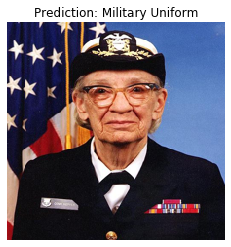

In [31]:
input = prepare_image_for_inference(image)
result = classifier.predict(input)
predicted_class = np.argmax(result[0], axis=-1)
plt.imshow(image)
plt.axis('off')
predicted_class_name = labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Save model as in TensorFlow Lite Format

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Load model and test inference using tensorflow lite

see: https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_python

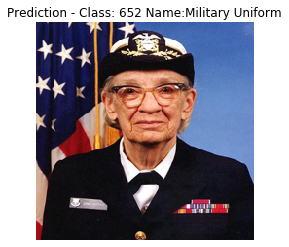

In [46]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], input.astype('float32') )

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data[0], axis=-1)
predicted_class
plt.imshow(image)
plt.axis('off')
predicted_class_name = labels[predicted_class]
_ = plt.title(f"Prediction - Class: {predicted_class} Name:{predicted_class_name.title()}" )

# Build dependencies and upload model

In [89]:
!pip3 install https://dl.google.com/coral/python/tflite_runtime-2.1.0.post1-cp36-cp36m-linux_x86_64.whl -t dependencies

  Using cached https://dl.google.com/coral/python/tflite_runtime-2.1.0.post1-cp36-cp36m-linux_x86_64.whl (1.9 MB)
  Using cached numpy-1.19.0-cp36-cp36m-manylinux2010_x86_64.whl (14.6 MB)


In [48]:
!mkdir -p model_package
!mv labels.txt model.tflite dependencies model_package
!tar -zcvf model.tar.gz model_package

create the bucket if it doesn't exist

In [74]:
import boto3
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = f'greengrass-deployment-{account_id}'
s3client = boto3.client('s3')
s3client.create_bucket(
    Bucket=bucket_name,
    CreateBucketConfiguration={
        'LocationConstraint': sagemaker.Session().boto_region_name
    }
    
)

{'ResponseMetadata': {'RequestId': '82EA2BB573685F00',
  'HostId': '1QJKEwvmV6Q0aUxte2XmQjsd+UCcpLjXyCbaAQvODi8Ytz44SKijgp6jtfLDgz+HR+uV+Gp0Rnk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '1QJKEwvmV6Q0aUxte2XmQjsd+UCcpLjXyCbaAQvODi8Ytz44SKijgp6jtfLDgz+HR+uV+Gp0Rnk=',
   'x-amz-request-id': '82EA2BB573685F00',
   'date': 'Sat, 18 Jul 2020 11:57:07 GMT',
   'location': 'http://greengrass-deployment-828266890613.s3.amazonaws.com/',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': 'http://greengrass-deployment-828266890613.s3.amazonaws.com/'}

Upload model to bucket

In [75]:
from datetime import datetime
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%Y%m%d-%H%M%S")
timestampStr

'20200718-115712'

In [76]:
!aws s3 cp model.tar.gz s3://greengrass-deployment-828266890613/models/{timestampStr}/model.tar.gz

upload: ./model.tar.gz to s3://greengrass-deployment-828266890613/models/20200718-115712/model.tar.gz
